In [41]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import matplotlib.ticker as plticker
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from collections import defaultdict
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff
import torch
import pytorch_lightning as pl
from torch import nn

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from data.dataset import PDEDataset, PDEDataModule
from data.utils import d_to_LT
from misc.utils import load_obj

from model.setup import setup_model
from model.networks.fno import FNO1d
from model.networks.cnn import CNN, ResNet, BasicBlock1d, ResNet_conv
from model.learner import Learner

from model.networks.fno import FNO1d

from viz.plot_pde_data import plot_1ds, plot_1d_dict
from misc.utils import load_obj, save_obj

from run import parse_options, main

from model.networks.single_sym.magnitude import Conv1dMag, Conv2dMag
from misc.equiv import assert_equiv


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
args = parse_options(notebook=True)
args.train = True
args.pde_name = 'KdV'
args.data_dir = '../data/test'
args.net = 'ResNet_conv'
args.max_epochs = 3
args.batch_size = 3
args.num_workers = 0
args.persistent_workers = False
args.verion = None
args.do_return = True

args.seed = 52
args.epsilons = [0., 1., 0.1, 0.4]

model, trainer, datamodule = main(args)
model.eval();

Seed set to 52
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs




###	Version:  None 	###
###	Name:  datatest_netResNet_conv_KdV_aug0.0-1.0-0.1-0.4_seed52 	###


equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
Selecting 10 out of the 10 train samples!
Augmenting KdV with epsilons [0.0, 1.0, 0.1, 0.4]!
Selecting 2 out of the 2 val samples!
Selecting 2 out of the 2 test samples!


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [43]:
mult = torch.rand(args.batch_size)
def mag_mult(x):

    # if isinstance(x, tuple):
    #     print('x is tuple!')
    #     x = x[0]

    shape = x.shape
    batch_size = shape[0]
    lens = np.ones(len(shape)-1)
    lens = lens.astype(int)
    lens = np.append(batch_size, lens)
    mult2 = mult.view(*lens)
    return x * mult2
print(mult)

tensor([0.3157, 0.6259, 0.2388])


In [44]:
time_history = 10
time_future = 5
embed_spacetime = False
equiv = 'mag'

In [38]:
us, dxs, dts = next(iter(datamodule.train_dataloader()))

us = us[:, :time_history, :128]
print(us.shape, dxs.shape, dts.shape)

batch = (us, dxs, dts)

torch.Size([3, 10, 128]) torch.Size([3]) torch.Size([3])


In [45]:
block = BasicBlock1d(time_history, 20, equiv = 'mag')

y1, y2 = assert_equiv(us, mag_mult, block, atol=1e-6, print_only=True)

equiv mag
shortcut
Equivariance test passed.


In [46]:
net = ResNet_conv(BasicBlock1d, [2, 2, 2, 2], time_history=time_history, time_future=time_future, embed_spacetime=embed_spacetime, equiv = equiv)

equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
equiv mag


In [95]:
net = ResNet_conv(BasicBlock1d, [2, 2, 2, 2], time_history=time_history, time_future=time_future, embed_spacetime=embed_spacetime, equiv = 'mag')
y1, y2 = assert_equiv(us, mag_mult, net, atol=1e-6, print_only=True)

equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
equiv mag
Equivariance test failed. 
Max difference:  0.0230032 
Mean difference: 0.00461734


In [23]:
y_pred, y = model(batch)

In [162]:
mult = torch.rand(args.batch_size)
def mag_mult(x):
    shape = x.shape
    batch_size = shape[0]
    lens = np.ones(len(shape)-1)
    lens = lens.astype(int)
    lens = np.append(batch_size, lens)
    mult2 = mult.view(*lens)
    return x * mult2
print(mult)

tensor([0.2482, 0.5882, 0.8077])


In [151]:
x1d = torch.load('../ext_repos/Equivariant-Net/x1d.pt')
x1d.shape

torch.Size([3, 48, 64])

In [167]:
x = us

print(x.shape)

conv1d_mag = Conv1dMag(
    input_channels = x.shape[1],
    output_channels = 5,
    kernel_size = 3,
)

# x = (x - x.mean() ) / x.std()

print(x.mean(), x.std())
y1, y2 = assert_equiv(x, mag_mult, conv1d_mag, atol=1e-6, print_only=True)


torch.Size([3, 40, 128])
tensor(0.1947) tensor(0.2803)
Equivariance test passed.


### E2CNN

In [ ]:
datamodule = PDEDataModule(
    pde_name = args.pde_name, 
    data_dir = args.data_dir, 
    batch_size = args.batch_size, 
    num_workers = args.num_workers,
    n_splits = [int(n_split) for n_split in args.n_splits],
    generators = args.generators,
    persistent_workers = args.persistent_workers,
)
datamodule.setup()
batch = next(iter(datamodule.train_dataloader()))

Selecting 20 out of the 4000 train samples!
Selecting 20 out of the 500 val samples!
Selecting 20 out of the 500 test samples!


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pyt

The 1D ResNet has 8 convolutional layers using residual connections and increasing receptive fields (kernel size 3 to kernel size 15) a

In [ ]:
net = CNN(
    # block = BasicBlock1d,
    # num_blocks = [2, 2, 2, 2],
    time_history = 10,
    time_future  = 5,
)

model = Learner(net, nn.MSELoss())

y_pred, y = model(batch)
y_pred = y_pred.detach().numpy()

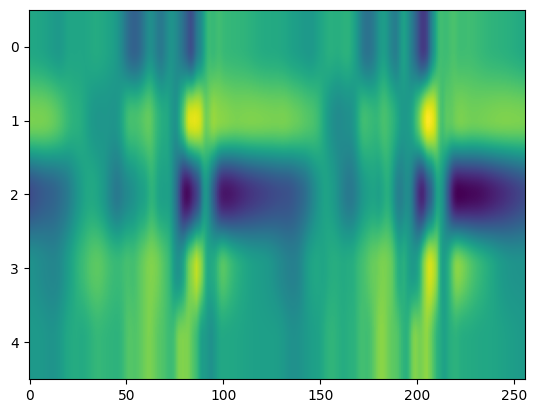

In [ ]:
plt.imshow(y_pred[0], aspect='auto')

In [ ]:
# args.generators = False
# args.do_return = False

# # model, trainer, datamodule = main(args)

In [ ]:
dataset_train = datamodule.train_dataloader().dataset

In [ ]:
datamodule.setup(stage='test')
batch = next(iter(datamodule.train_dataloader()))

Selecting 20 out of the 4000 train samples!
Augmenting KdV!
Selecting 20 out of the 500 val samples!
Selecting 20 out of the 500 test samples!


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pyt

In [ ]:
# set to inference mode
model.eval()

Learner(
  (net): FNO1d
)

In [ ]:
def flip_batch(batch):
    batch_flipped = batch.copy()
    batch_flipped[0] = batch_flipped[0].flip(2)
    return batch_flipped

def flip_y(y):
    y_flipped = y.clone()
    y_flipped = y_flipped.flip(2)
    return y_flipped

def pred(batch):
    y_pred, y = model(batch)
    y_pred = y_pred.detach()
    y = y.detach()
    return y_pred, y

In [ ]:
y_pred1, y1 = pred(batch)
y_pred_flipped1, y_flipped1 = flip_y(y_pred1), flip_y(y1)

In [ ]:
batch_flipped = flip_batch(batch)
y_pred_flipped2, y_flipped2 = pred(batch_flipped)

In [ ]:
(y_flipped1 == y_flipped2).all(), (y_pred_flipped1 == y_pred_flipped2).all()

(tensor(True), tensor(False))

In [ ]:
_, dx, dt = batch

In [ ]:
diff = (y_pred_flipped1-y_pred_flipped2)

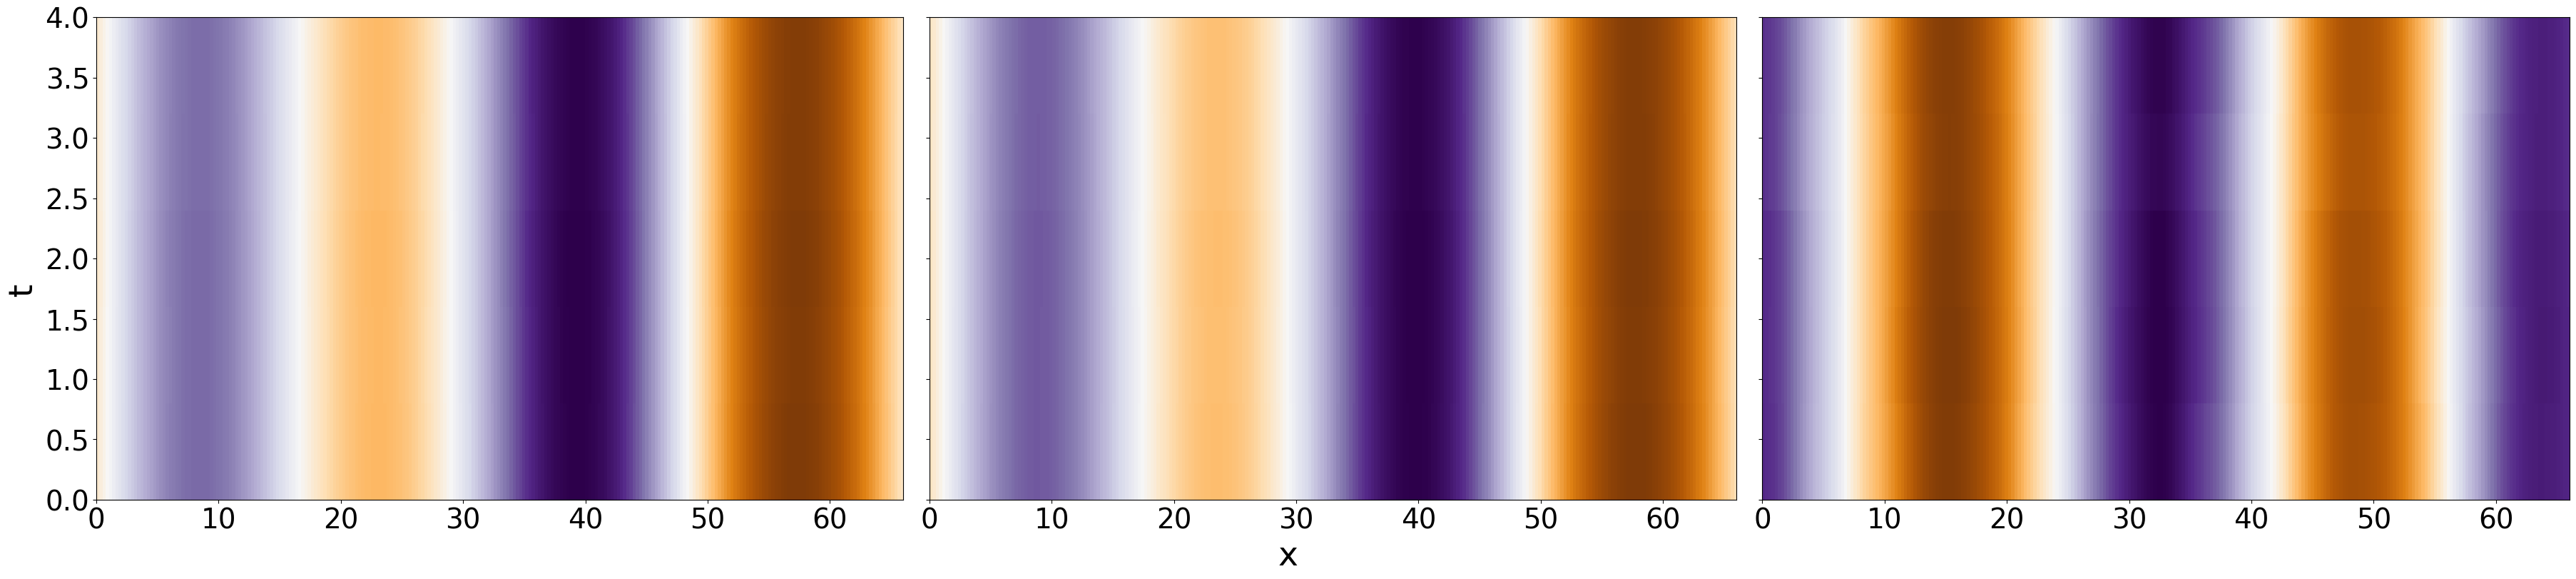

In [ ]:
plots = [y_pred_flipped1, y_pred_flipped2, diff]

plot_1ds(torch.cat(plots).unsqueeze(0), dx, dt, vminmax = False)

In [ ]:
plots_dict = {
    'y_flips' : [y_pred_flipped1, y_pred_flipped2, y_pred_flipped1-y_pred_flipped2]
}

plot_1d_dict(plots_dict)

NameError: name 'plot_1d_dict' is not defined

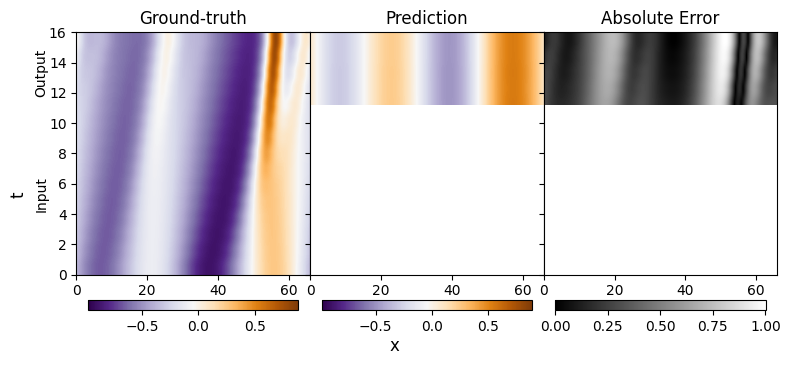

In [ ]:
model.log_fig(batch_flipped, y_pred_flipped1)

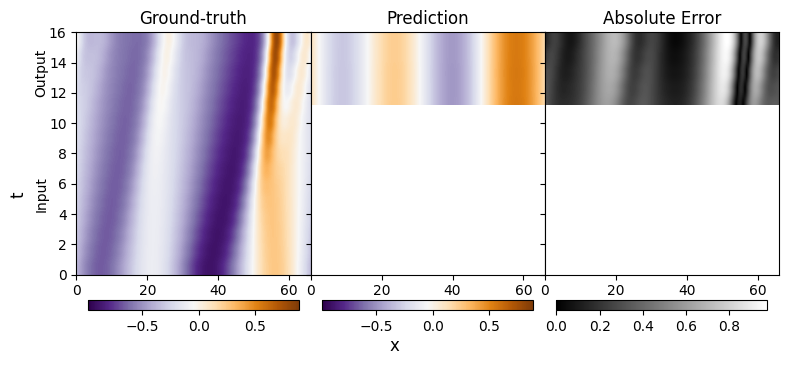

In [ ]:
model.log_fig(batch_flipped, y_pred_flipped2)


## G-FNO

In [ ]:
num_channels = 1
modes = 12
width = 10 # for G-FNO p4, for G-FNO p4m then 7
T_in = initial_step = 10 # input time (history)
reflection = False # False if p4, if p4m then True
grid_type = 'symmetric'
strategy = 'teacher_forcing'
T = 20
noise_std = 0

In [ ]:
from model.networks.gfno import GFNO2d, pde_data

In [ ]:
model = GFNO2d(
    num_channels=num_channels,
    modes=modes,
    width=width,
    initial_step=initial_step,
    reflection=reflection,
    grid_type=grid_type,
)

In [ ]:
# x = us[:, :10, :]
# model(x)

In [ ]:
data_path = '../ext_repos/G-FNO/data'

train_path = os.path.join(data_path, 'ns_V0.01_N10_T30_cos4_super.mat')
data = scipy.io.loadmat(os.path.expandvars(train_path))['u'].astype(np.float32)
data = torch.from_numpy(data).float()
print(data.shape)
data = data.unsqueeze(-1)
print(data.shape)

In [ ]:
train_dataset = pde_data(data, strategy=strategy, T_in=T_in, T_out=T, std=noise_std)

In [ ]:
x, y = train_dataset[0]

In [ ]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

In [ ]:
xx, yy = next(iter(dataloader))

In [ ]:
x_pred = model(xx)

In [ ]:
x_pred.shape

In [ ]:
x.shape, y.shape